# ELEC474 Project

In [14]:
import cv2 as cv
import numpy as np
import os

from cv2 import Stitcher
from matplotlib import pyplot as plt

In [15]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

dirName1 = 'office2'
dirName2 = 'StJames'
dirName3 = 'WLH'

Process_BarLength = 30

BEST_MATCH_METRIC = 200 #StJames is 85, office2 is 200, WLH is 100
LOWE_RATIO = 0.7
SEED_IDX = 0

# Step 1

In [16]:
class MatcheClass:
    def __init__(self, keypoint, descriptors, match):
        self.keypoints = keypoint
        self.descriptors = descriptors
        self.matchs = match
        self.img1 = []
        self.img2 = []
    
    def LoadImg1(self, img):
        self.img1 = img
    
    def LoadImg2(self, img):
        self.img2 = img
    
    def __eq__(self, other) -> bool:
        return self.__dict__ == other.__dict__
        

In [17]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

def FetchingImgs(dirName):
    ls = []
    dir = os.getcwd()+'//'+dirName
    files = os.listdir(dir)
    for filename in files:

        if os.path.splitext(filename)[1] == '.jpg':
            ls.append(filename)
    if ls.count != 0:
        print("Detected: \n",ls)
    return ls

def ProgressionBarUpdate(current,overall):
    pctge = (current+1) / overall
    if pctge > 1:
        pctge = 1
    temp = int(round(Process_BarLength * pctge))
    print('\r%s%s%s%s'% ((temp)*'█',(Process_BarLength-temp)*'░',str(round(pctge*100)),'%'), end = ' ')


def ReadImgs(dirName, imgName):
    return cv.imread(os.getcwd()+'//'+dirName+'//'+imgName)

In [18]:
def FindDescriptorAndKeyPoints(img,flag,descriptor = my_SIFT_instance): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = descriptor.detectAndCompute(imgGray,None)
    return (kp,des)

def FlannBasedMatchLoweRatio(descriptor1,descriptor2,   
                            index_param,search_param,
                            kNum, ratio):
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(descriptor1,descriptor2,k = kNum)

    loweMatch = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])
    return loweMatch

In [19]:

def Matching(ds1, ds2, loweRatio):
    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    Matches = FlannBasedMatchLoweRatio(ds1[1], ds2[1],
                            index_params, search_params,
                            kNum = 2, ratio = loweRatio)  #NOTE: The ratio difference of lowe will result in different epiploar lines 
    
    return MatcheClass([ds1[0],ds2[0]], [ds1[1], ds2[1]], Matches)

In [20]:

def MatchingFeaturesOfImages(dirName, descriptorMethod):
    idx = 0
    numGoodMatch = 0
    imgList = []
    matchList = []
    descKpList = []

    # detect and extract features from the image
    if descriptorMethod == 'sift':
        descriptor = cv.xfeatures2d.SIFT_create()
    elif descriptorMethod == 'surf':
        descriptor = cv.xfeatures2d.SURF_create()
    elif descriptorMethod == 'brisk':
        descriptor = cv.BRISK_create()
    elif descriptorMethod == 'orb':
        descriptor = cv.ORB_create()
    
    print("Featching Images under Dir and creating descriptors for them")
    imgNameList = FetchingImgs(dirName)
    for imgName in imgNameList:
        idx += 1
        ProgressionBarUpdate(idx, len(imgNameList)+1)
        temp = ReadImgs(dirName, imgName)
        imgList.append(temp)
        descKpList.append(FindDescriptorAndKeyPoints(temp,flag=1, descriptor = descriptor))
        

    print("\nFind best Match for each pair of imgs")
    seedIdx = SEED_IDX
    seedImg = imgList[seedIdx]
    seedDescKp = descKpList[seedIdx]
    
    imgListIdx = list(range(len(imgList)))
    imgListIdx.remove(seedIdx)
    
    for imgIdx in imgListIdx:
        ProgressionBarUpdate(imgIdx+1,len(imgList)-1)
        
        temp = Matching(seedDescKp, descKpList[imgIdx], LOWE_RATIO)
        if len(temp.matchs) > BEST_MATCH_METRIC:
            numGoodMatch+=1
            temp.LoadImg1(seedImg)
            temp.LoadImg2(imgList[imgIdx])
            matchList.append(temp)
    
    print("\nThere are", numGoodMatch, "good Image Pairs has been find")
        
    return matchList

        

In [21]:

m1 = MatchingFeaturesOfImages(dirName1, descriptorMethod='sift')

Featching Images under Dir and creating descriptors for them
Detected: 
 ['20191119_170646.jpg', '20191119_170650.jpg', '20191119_170652.jpg', '20191119_170653.jpg', '20191119_170655.jpg', '20191119_170657.jpg', '20191119_170658.jpg', '20191119_170700.jpg', '20191119_170702.jpg', '20191119_170704.jpg', '20191119_170706.jpg', '20191119_170707.jpg', '20191119_170709.jpg', '20191119_170711.jpg', '20191119_170712.jpg', '20191119_170714.jpg', '20191119_170715.jpg', '20191119_170717.jpg', '20191119_170719.jpg', '20191119_170721.jpg', '20191119_170723.jpg', '20191119_170725.jpg', '20191119_170727.jpg', '20191119_170729.jpg', '20191119_170730.jpg', '20191119_170732.jpg', '20191119_170733.jpg', '20191119_170735.jpg', '20191119_170737.jpg']
██████████████████████████████100% 
Find best Match for each pair of imgs
██████████████████████████████100% 
There are 6 good Image Pairs has been find


# Step 2,3

In [22]:
def DirctionAndHomoFind(M: MatcheClass):
    leftList = []
    rightList = []
    for currentMatch in M:
        
        seedImg = currentMatch.img1
        cmprImg = currentMatch.img2
        ref_kyPt = currentMatch.keypoints[0]
        img_kyPt = currentMatch.keypoints[1]
        matches = currentMatch.matchs

        ref_pts = np.float32([ref_kyPt[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
        img_pts = np.float32([img_kyPt[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
        
        M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) # invert img_pts and ref_pts to get inverse of normal M_p
        M_p_inv = np.linalg.inv(M_p)
        dirTestPt = np.dot(M_p_inv,[0,0,1])
        
        print(dirTestPt)
        if dirTestPt[0] > 0: 
            print("is Left Image")
            leftList.append(cmprImg)
        else:
            print("is Right Imgae")
            rightList.append(cmprImg)


    
    return seedImg, leftList, rightList
    


In [23]:
def findHomoInSitch(img1, img2):
    img1Para = FindDescriptorAndKeyPoints(img1,flag=0)
    img2Para = FindDescriptorAndKeyPoints(img2,flag=0)
    match = Matching(img1Para, img2Para, LOWE_RATIO)
    
    img_kyPt = img2Para[0]
    ref_kyPt = img1Para[0]
    matches = match.matchs

    img_pts = np.float32([img_kyPt[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
    ref_pts = np.float32([ref_kyPt[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)

    H, s = cv.findHomography(img_pts, ref_pts, cv.RANSAC, 4)
    
    return H

In [24]:
def StichImges(seedImage, leftList, rightList):
    mainImg = seedImage
    idx = 0
    
    print("Start Combine Left Imges")
    a = leftList[0]
    for b in leftList[1:]:
        H = findHomoInSitch(a,b)
        xh = np.linalg.inv(H)

        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = (int(ds[0])+offsetx*2, int(ds[1])+offsety*2)
        
        
        tmp = cv.warpPerspective(a, xh, dsize)
        tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
        PltImg([a,b,tmp],["source","comp","warp"])
        a = tmp
        idx += 1 
        ProgressionBarUpdate(idx, len(leftList))
    print("\nStart Choping left combination")
    leftComb = ChopBlackSide(a)
    
    print("\nStart Combine Right Imges")
    idx = 0
    o = leftComb
    for each in rightList:
            H = findHomoInSitch(o,each)
            txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
            txyz = txyz/txyz[-1]
            
            f1 = np.dot(xh, np.array([0,0,1]))
            f1 = f1/f1[-1]
            xh[0][-1] += abs(f1[0])
            xh[1][-1] += abs(f1[1])
            
            offsety = abs(int(f1[1])) + int(txyz[0])
            offsetx = abs(int(f1[0])) + int(txyz[1])
            
            dsize = (o.shape[1]+offsetx, o.shape[0]+offsety)
            tmp = cv.warpPerspective(each, H, dsize)
            tmp = mix_and_match(o, tmp)
            PltImg([tmp, each, o],["result", "comp", "source"])
            o = ChopBlackSide(tmp)
            
            idx += 1 
            ProgressionBarUpdate(idx, len(rightList))
            
    finalResult = o
    PltImg([finalResult],["Final Result"])
            
def mix_and_match(leftImage, warpedImage):
    
    i1y, i1x = leftImage.shape[:2]
    for i in range(0, i1x):
        for j in range(0, i1y):
            try:
                if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
                    warpedImage[j,i] = [0, 0, 0]
                else:
                    if(np.array_equal(warpedImage[j,i],[0,0,0])):
                        warpedImage[j,i] = leftImage[j,i]
                    else:
                        if not np.array_equal(leftImage[j,i], [0,0,0]):
                            bl,gl,rl = leftImage[j,i]
                            warpedImage[j, i] = [bl,gl,rl]
            except:
                pass
    return warpedImage


def ChopBlackSide(img):
    image = img 
    img = cv.medianBlur(image, 5)
    gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    _, th = cv.threshold(gray_img, 1, 255, cv.THRESH_BINARY)
    contour, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnt = contour[0]
    # print("size",cnt)
    x,y,w,h = cv.boundingRect(cnt)
    cropImg = img[y:y+h, x:x+w]
    
    PltImg([cropImg],"Chop"),
    return cropImg

In [25]:
seed, lList,rList = DirctionAndHomoFind(m1)   

[-403.21567458 -217.95049371    0.96004238]
is Right Imgae
[-9.08321947e+02 -6.00408287e+02  8.22282995e-01]
is Right Imgae
[-1.60583604e+03 -1.19103621e+03  5.08026427e-01]
is Right Imgae
[ 4.21099210e+02 -6.69872825e+01  3.42483897e-01]
is Left Image
[ 527.73888703 -294.11626706    0.76896777]
is Left Image
[ 295.42632221 -256.34550761    0.8995148 ]
is Left Image


Start Combine Left Imges
██████████████████████████████100% 
Start Choping left combination

Start Combine Right Imges
██████████████████████████████100% 

<Figure size 1800x1200 with 0 Axes>

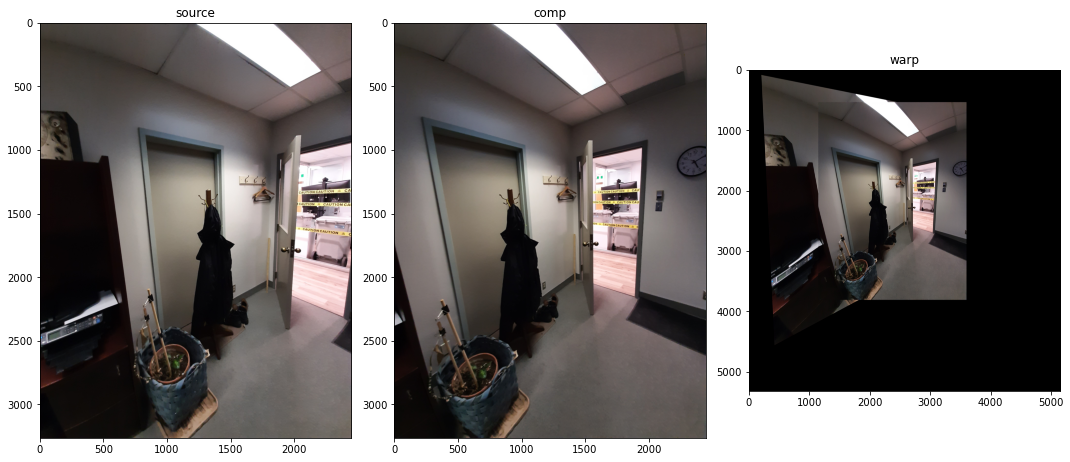

<Figure size 1800x1200 with 0 Axes>

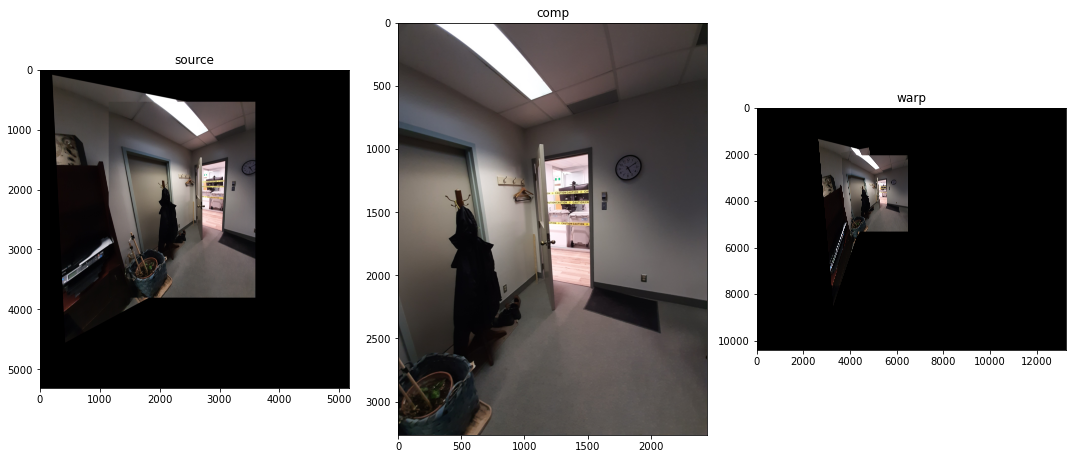

<Figure size 1800x1200 with 0 Axes>

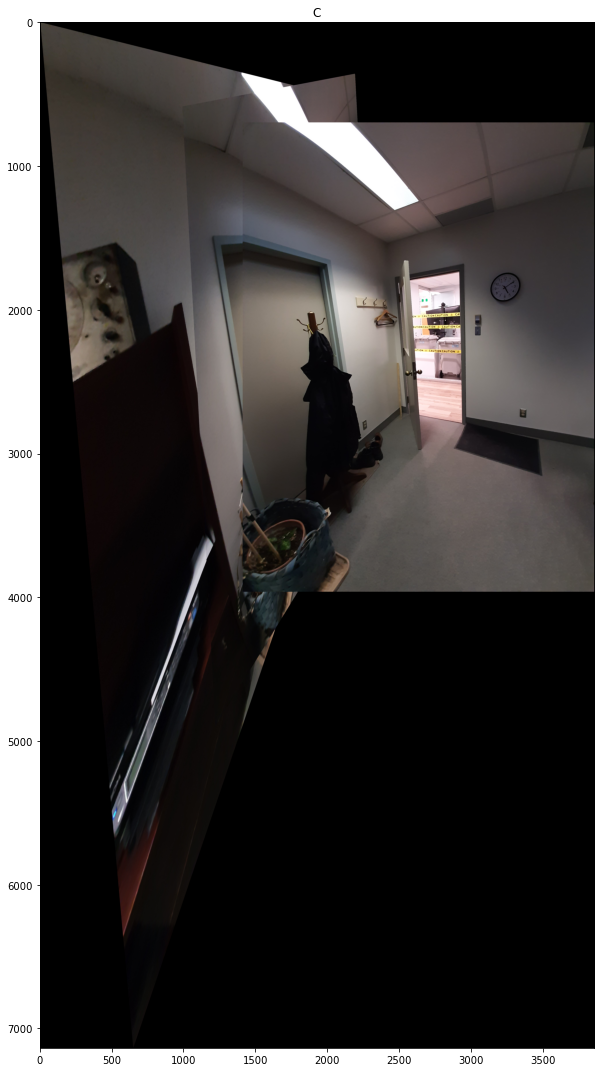

<Figure size 1800x1200 with 0 Axes>

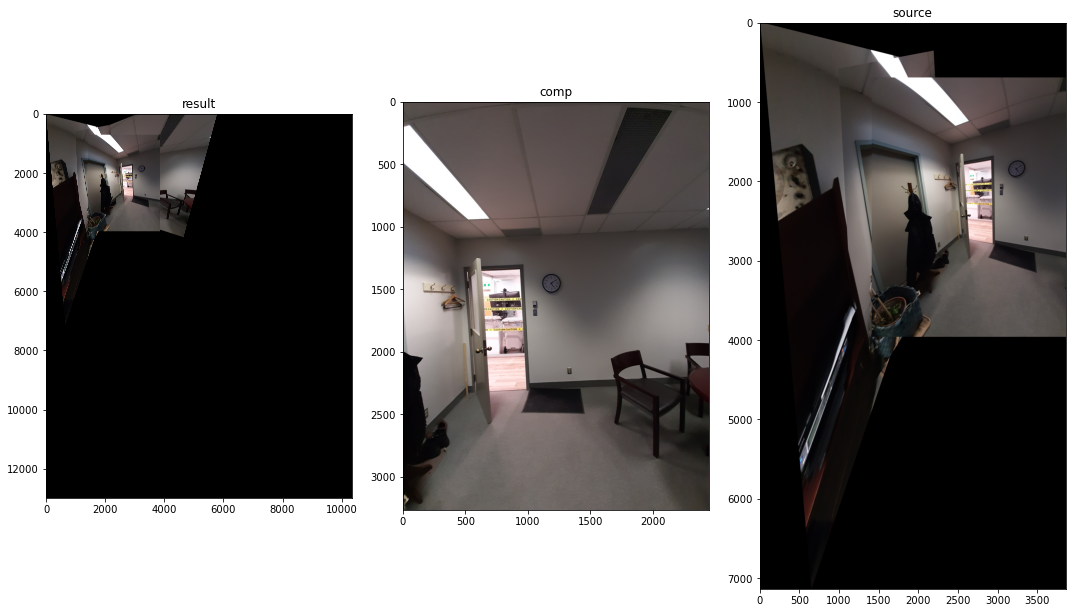

<Figure size 1800x1200 with 0 Axes>

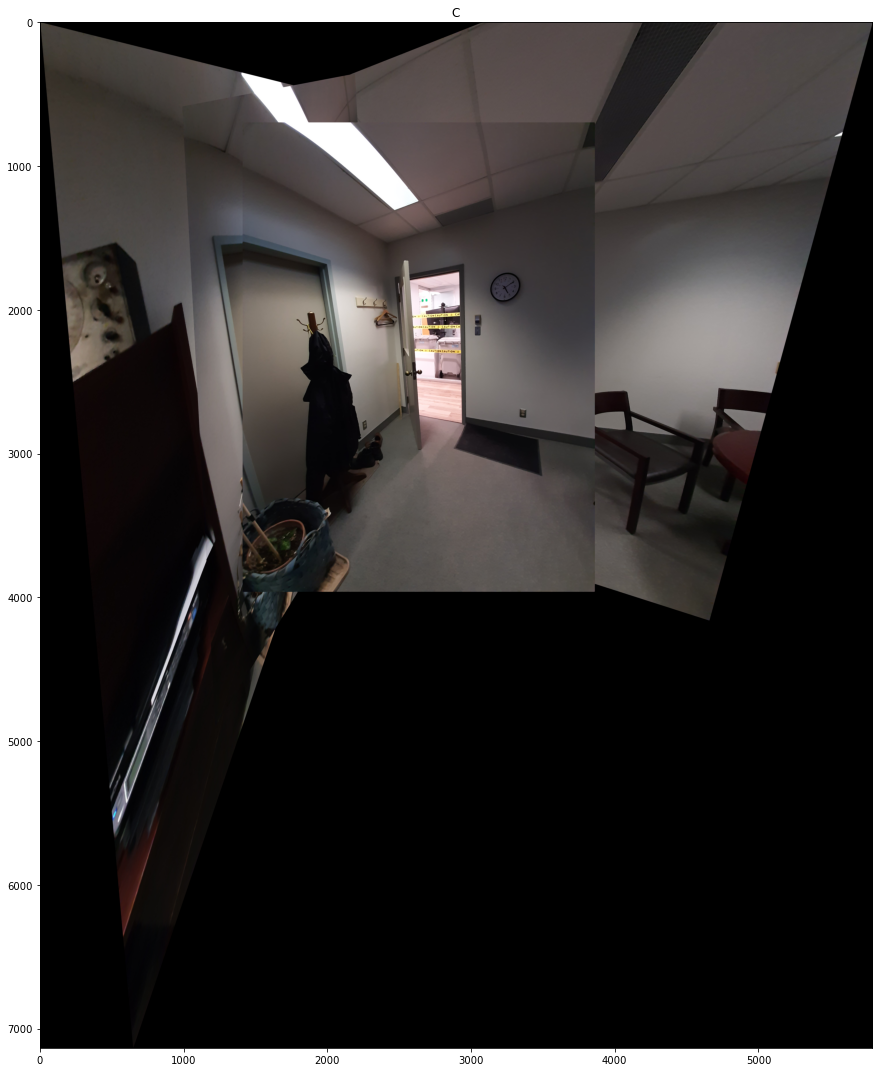

<Figure size 1800x1200 with 0 Axes>

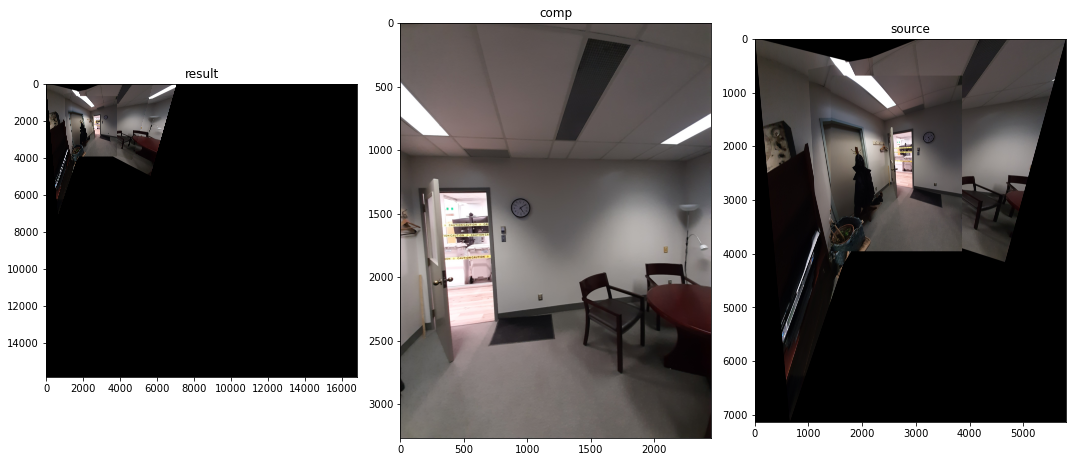

<Figure size 1800x1200 with 0 Axes>

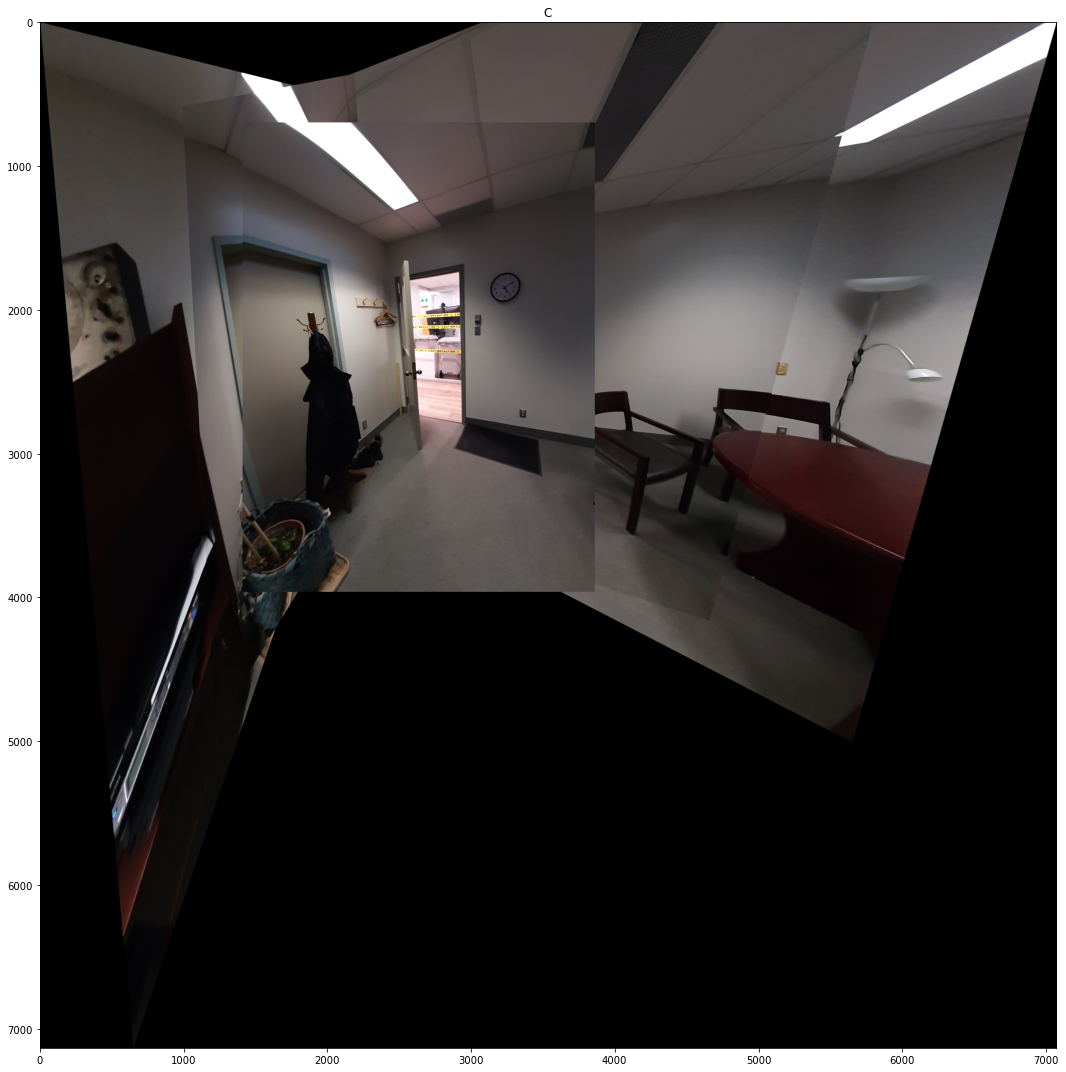

<Figure size 1800x1200 with 0 Axes>

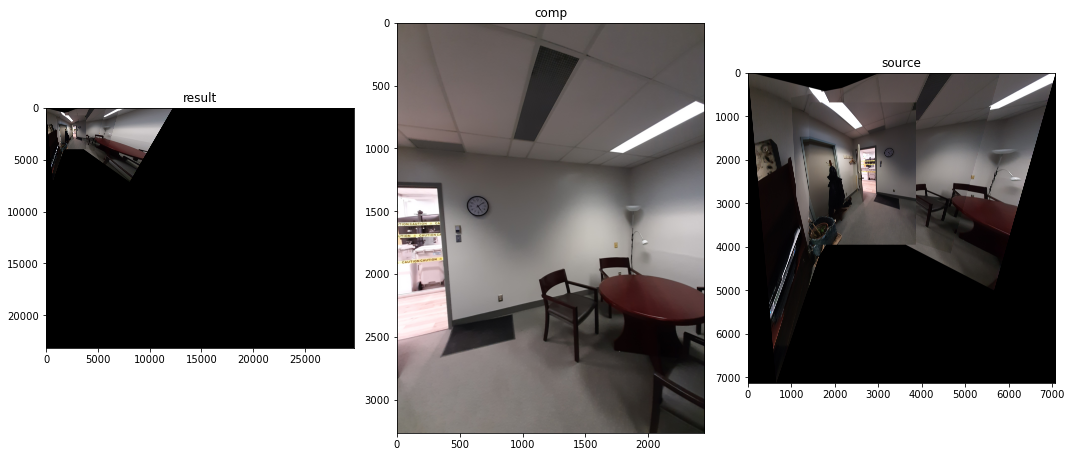

<Figure size 1800x1200 with 0 Axes>

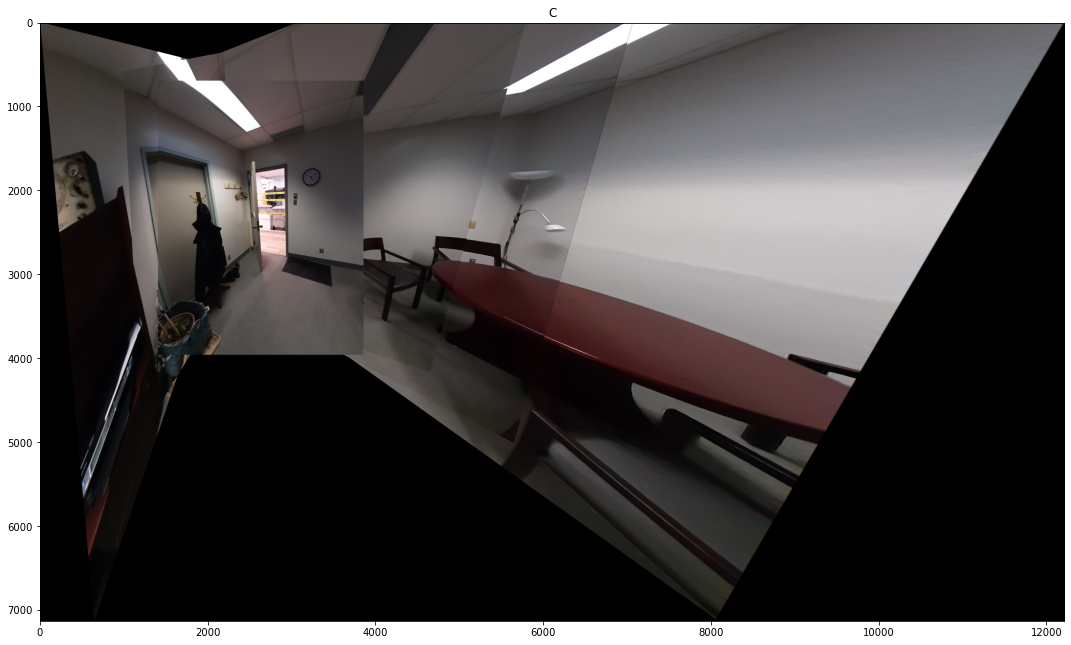

<Figure size 1800x1200 with 0 Axes>

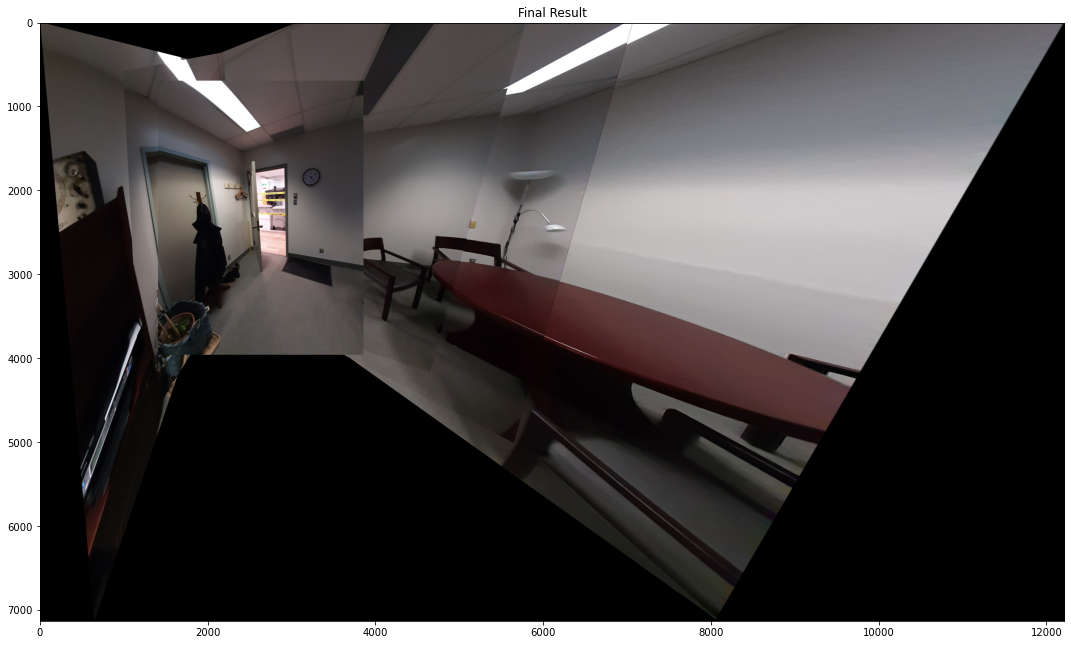

In [26]:
StichImges(seed, lList, rList)